In [1]:
!pip install pretty_errors
!pip install pyspark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/ML Project'

/content/drive/MyDrive/ML Project


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pyspark.sql import SparkSession
import os, sys, matplotlib.pyplot as plt, seaborn as sns

In [6]:
import pretty_errors

In [7]:
from config import PROJECT_PATH

In [8]:
sys.path.append(os.path.join(PROJECT_PATH, 'Source'))

In [9]:
from data_visualization import *

In [10]:
train_dir = os.path.join(PROJECT_PATH, 'Datasets/fraudTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'Datasets/fraudTest.csv')

In [11]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np

In [12]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [67]:
all_data = train.union(test)
all_data.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

# Data Cleaning

In [ ]:
null_columns = {column: all_data.select(column).where(F.col(column).isNull()).count() for column in all_data.columns}
null_columns

{'_c0': 0,
 'trans_date_trans_time': 0,
 'cc_num': 0,
 'merchant': 0,
 'category': 0,
 'amt': 0,
 'first': 0,
 'last': 0,
 'gender': 0,
 'street': 0,
 'city': 0,
 'state': 0,
 'zip': 0,
 'lat': 0,
 'long': 0,
 'city_pop': 0,
 'job': 0,
 'dob': 0,
 'trans_num': 0,
 'unix_time': 0,
 'merch_lat': 0,
 'merch_long': 0,
 'is_fraud': 0}

In [14]:
all_data = all_data.dropDuplicates()

In [75]:
irrelevant_columns =  ['first', 'last', 'cc_num', 'trans_num', 'street', 'zip', 'city',]
others = [column for column in all_data.columns if column not in irrelevant_columns]
all_data = all_data.select(others)

# General info about customers

In [68]:
all_data = all_data.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))

In [19]:
cols = ['job', 'age', 'state', 'gender']
customers = all_data.select(cols).groupBy(cols).count().orderBy('count')

In [20]:
customers.show()

+--------------------+----+-----+------+-----+
|                 job| age|state|gender|count|
+--------------------+----+-----+------+-----+
|   Quantity surveyor|26.0|   IA|     F|    6|
|Armed forces trai...|92.0|   VA|     M|    7|
|   Warehouse manager|60.0|   MS|     F|    7|
|Horticultural con...|64.0|   TX|     F|    7|
|Community develop...|62.0|   TX|     M|    7|
|Sales promotion a...|61.0|   VA|     F|    7|
|Clinical cytogene...|54.0|   CA|     M|    7|
|Sales promotion a...|61.0|   IN|     F|    7|
|              Dancer|75.0|   NY|     F|    7|
|Aeronautical engi...|88.0|   IL|     F|    7|
|         Ship broker|25.0|   PA|     F|    7|
|Contracting civil...|80.0|   TN|     F|    7|
|Senior tax profes...|78.0|   NV|     F|    8|
|     Engineer, water|80.0|   MN|     F|    8|
|Chief Marketing O...|83.0|   FL|     M|    8|
|  Veterinary surgeon|58.0|   MI|     M|    8|
|Air traffic contr...|76.0|   NY|     M|    8|
|Pharmacist, hospital|56.0|   IN|     F|    8|
|Nature conse

In [21]:
# Total customers in the dataset
print(f'Total customers in the dataset is: {customers.count()}')

Total customers in the dataset is: 999


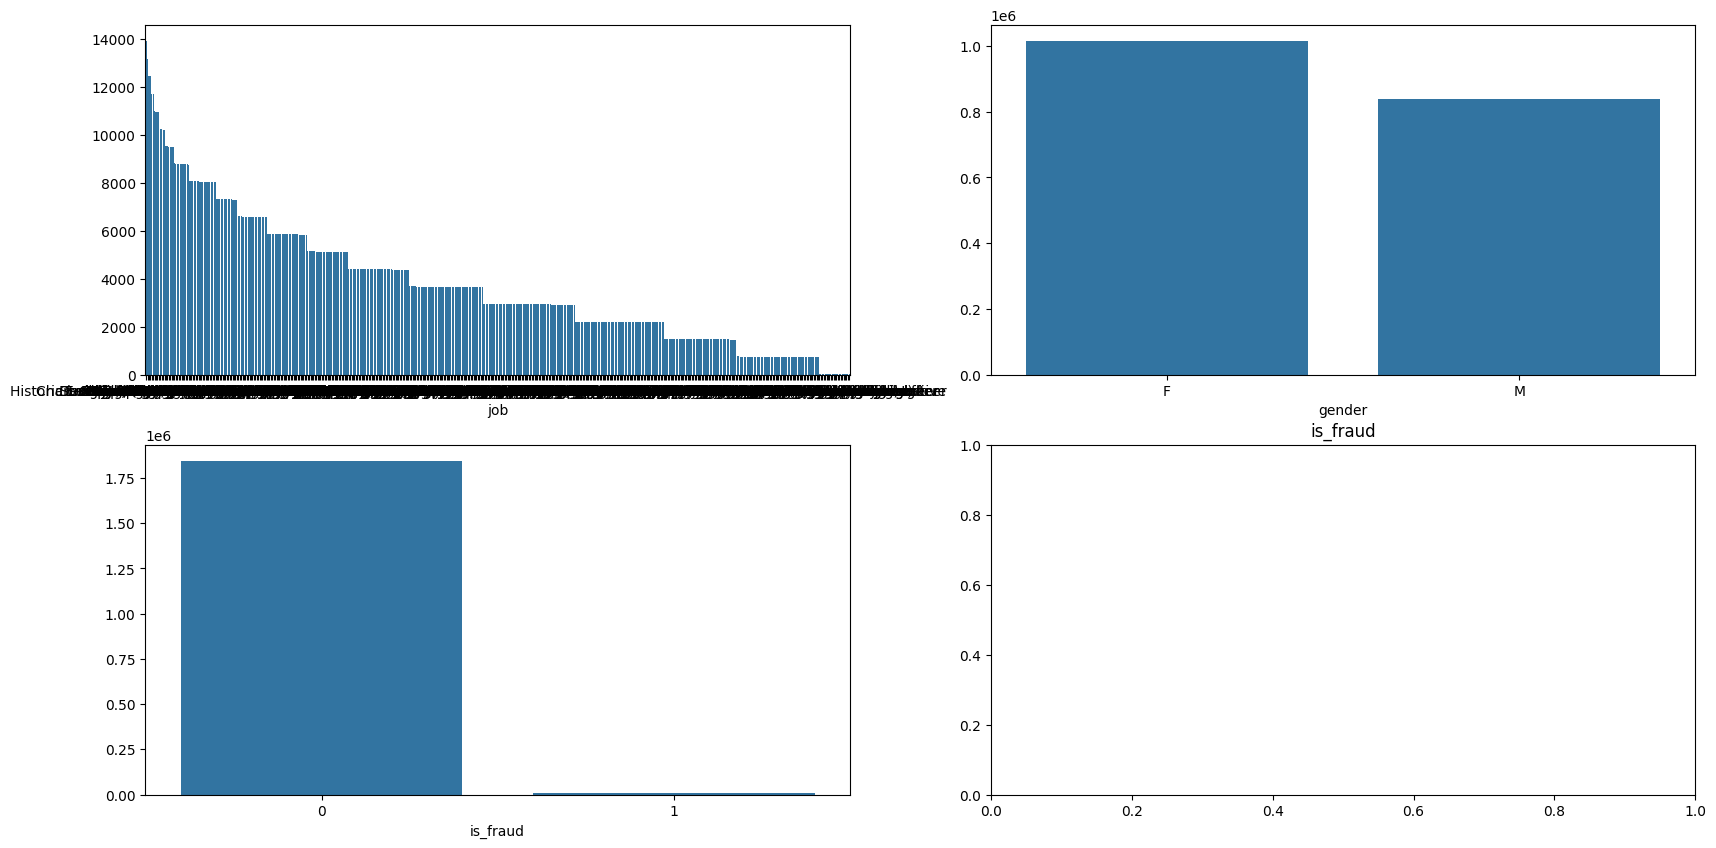

In [ ]:
columns = ['job', 'gender', 'is_fraud']
temp = all_data.select(columns)
barplots(temp, columns = columns, shape = (2, 2), figsize = (20, 10))

# Transaction date and time

In [69]:
all_data = all_data.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))

In [23]:
counts = all_data.groupby(['trans_hour', 'is_fraud']).count().orderBy('trans_hour')
counts = counts.withColumnRenamed('count', 'counts')
counts.show()

+----------+--------+------+
|trans_hour|is_fraud|counts|
+----------+--------+------+
|         0|       0| 59832|
|         0|       1|   823|
|         1|       0| 60503|
|         1|       1|   827|
|         2|       1|   793|
|         2|       0| 60003|
|         3|       1|   803|
|         3|       0| 60165|
|         4|       0| 59877|
|         4|       1|    61|
|         5|       0| 60008|
|         5|       1|    80|
|         6|       0| 60352|
|         6|       1|    54|
|         7|       1|    72|
|         7|       0| 60229|
|         8|       1|    59|
|         8|       0| 60439|
|         9|       1|    61|
|         9|       0| 60170|
+----------+--------+------+
only showing top 20 rows



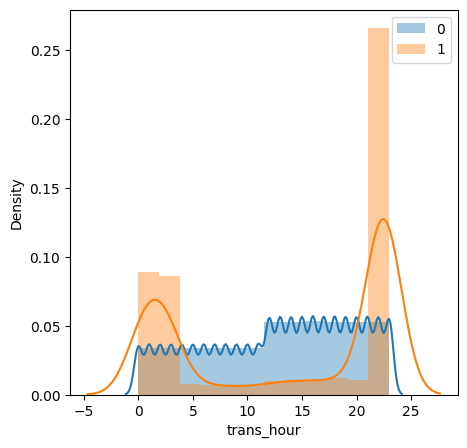

In [33]:
target_histograms(all_data.select('trans_hour', 'is_fraud').toPandas(),
                  x = ['trans_hour'],
                  y = 'is_fraud',
                  shape = (1, 1),
                  figsize = (5, 5),
                  params = {'bins': 12})

$$
P(x = \{0, ..., 23\}/y = \{0, 1\})
$$

In [ ]:
res = counts.groupBy('is_fraud').agg(F.sum('counts').alias('total_counts'))
res = res.select('total_counts').rdd.flatMap(lambda x: x).collect()
p_x_given_y1 = counts.where(F.col('is_fraud') == 1).select(F.col('counts') / res[0]).withColumnRenamed(f'(counts / {res[0]})', 'p_x_given_y1')
p_x_given_y0 = counts.where(F.col('is_fraud') == 0).select(F.col('counts') / res[1]).withColumnRenamed(f'(counts / {res[1]})', 'p_x_given_y0')

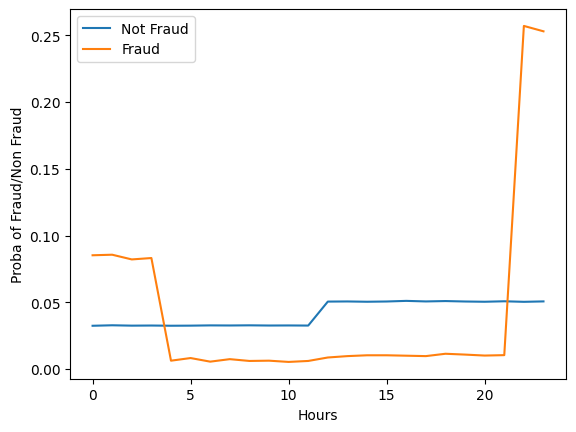

In [ ]:
plt.figure()
sns.lineplot(x = np.arange(0, 24),
             y = p_x_given_y0.select('p_x_given_y0').toPandas()['p_x_given_y0'], label = 'Not Fraud')
sns.lineplot(x = np.arange(0, 24),
             y = p_x_given_y1.select('p_x_given_y1').toPandas()['p_x_given_y1'], label = 'Fraud')
plt.xlabel('Hours')
plt.ylabel('Proba of Fraud/Non Fraud')
plt.legend()

`It seems that frauds are likely to happen at night after 21 and before the morning.`

# Amount, Age and unix_time columns

In [34]:
numerical_data = all_data.select('amt', 'age', 'unix_time', 'is_fraud', F.log('amt')).toPandas()
numerical_data.head()

,amt,age,unix_time,is_fraud,ln(amt)
0,89.35,29.0,1325379773,0,4.492561
1,81.72,36.0,1325391783,0,4.403299
2,101.82,31.0,1325393894,0,4.623207
3,7.81,41.0,1325397521,0,2.055405
4,2.86,34.0,1325421567,0,1.050822


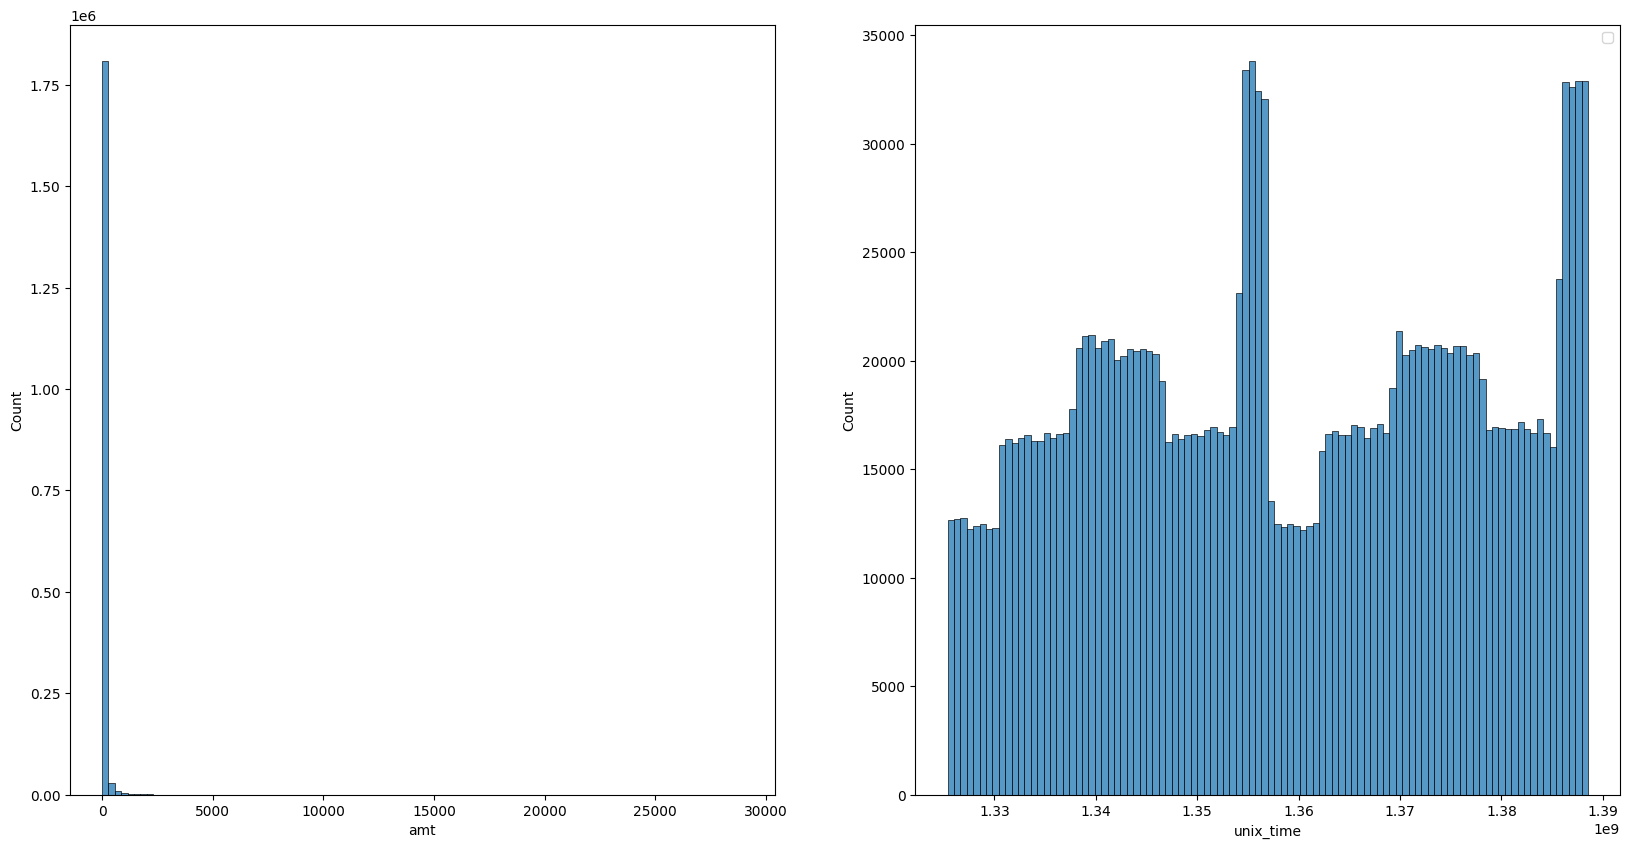

In [35]:
histograms(numerical_data, x = ['amt', 'unix_time'], shape = (1, 2), figsize = (20, 10), params = {'bins': 100})

`Amount column contains outliers`

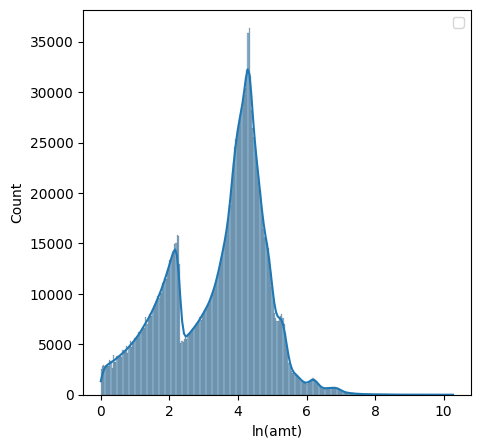

In [36]:
histograms(numerical_data, x = ['ln(amt)'], shape = (1, 1), figsize = (5, 5), params = {'kde': True})

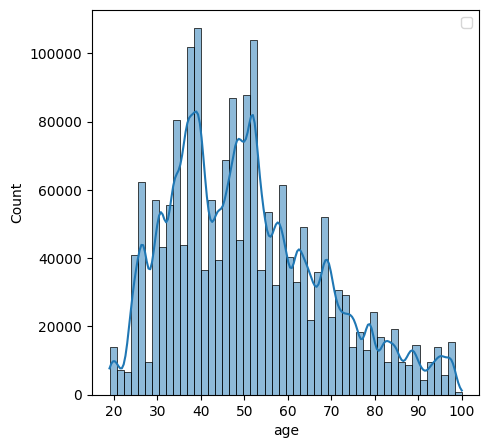

In [37]:
histograms(numerical_data, x = ['age'], shape = (1, 1), figsize = (5, 5), params = {'bins': 50, 'kde': True})

<Axes: ylabel='amt'>

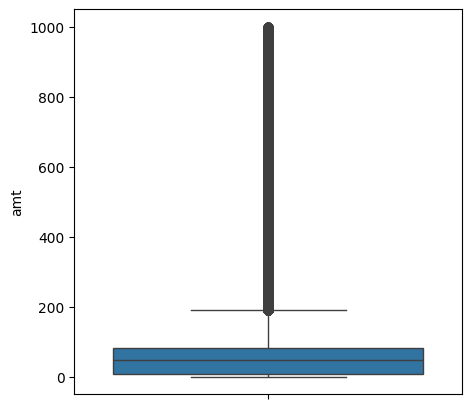

In [38]:
fig = plt.figure(figsize = (5, 5))
sns.boxplot(numerical_data[numerical_data['amt'] < 1000]['amt'])

In [39]:
q25, q50, q75 = np.percentile(numerical_data['amt'], [25, 5, 75])
iqr = q75 - q25
_min, _max = q25 - 1.5 * iqr, q75 + 1.5 * iqr
print(_min, q25, q50, q75, _max)

-100.55 9.64 2.44 83.1 193.29


In [40]:
# Number of rows considered as outilers
len(numerical_data) - len(numerical_data[numerical_data['amt'] < _max]['amt'])

95071

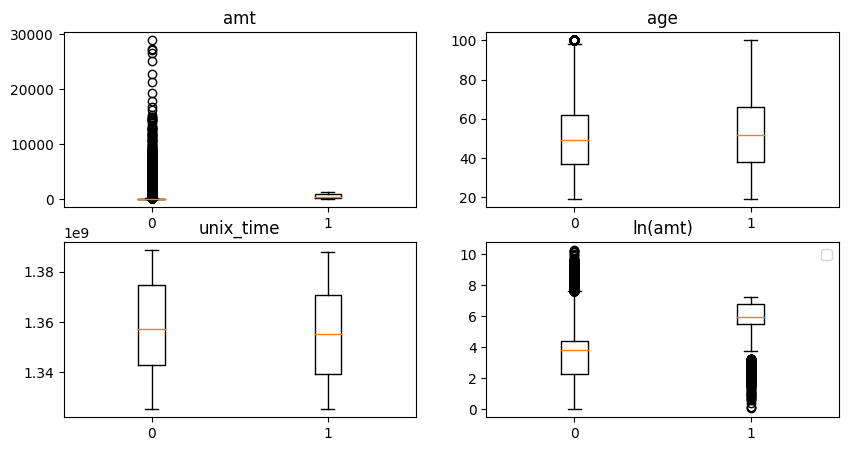

In [41]:
target_boxplots(numerical_data, x = ['amt', 'age', 'unix_time', 'ln(amt)'], y = 'is_fraud', shape = (2, 2), figsize = (10, 5))

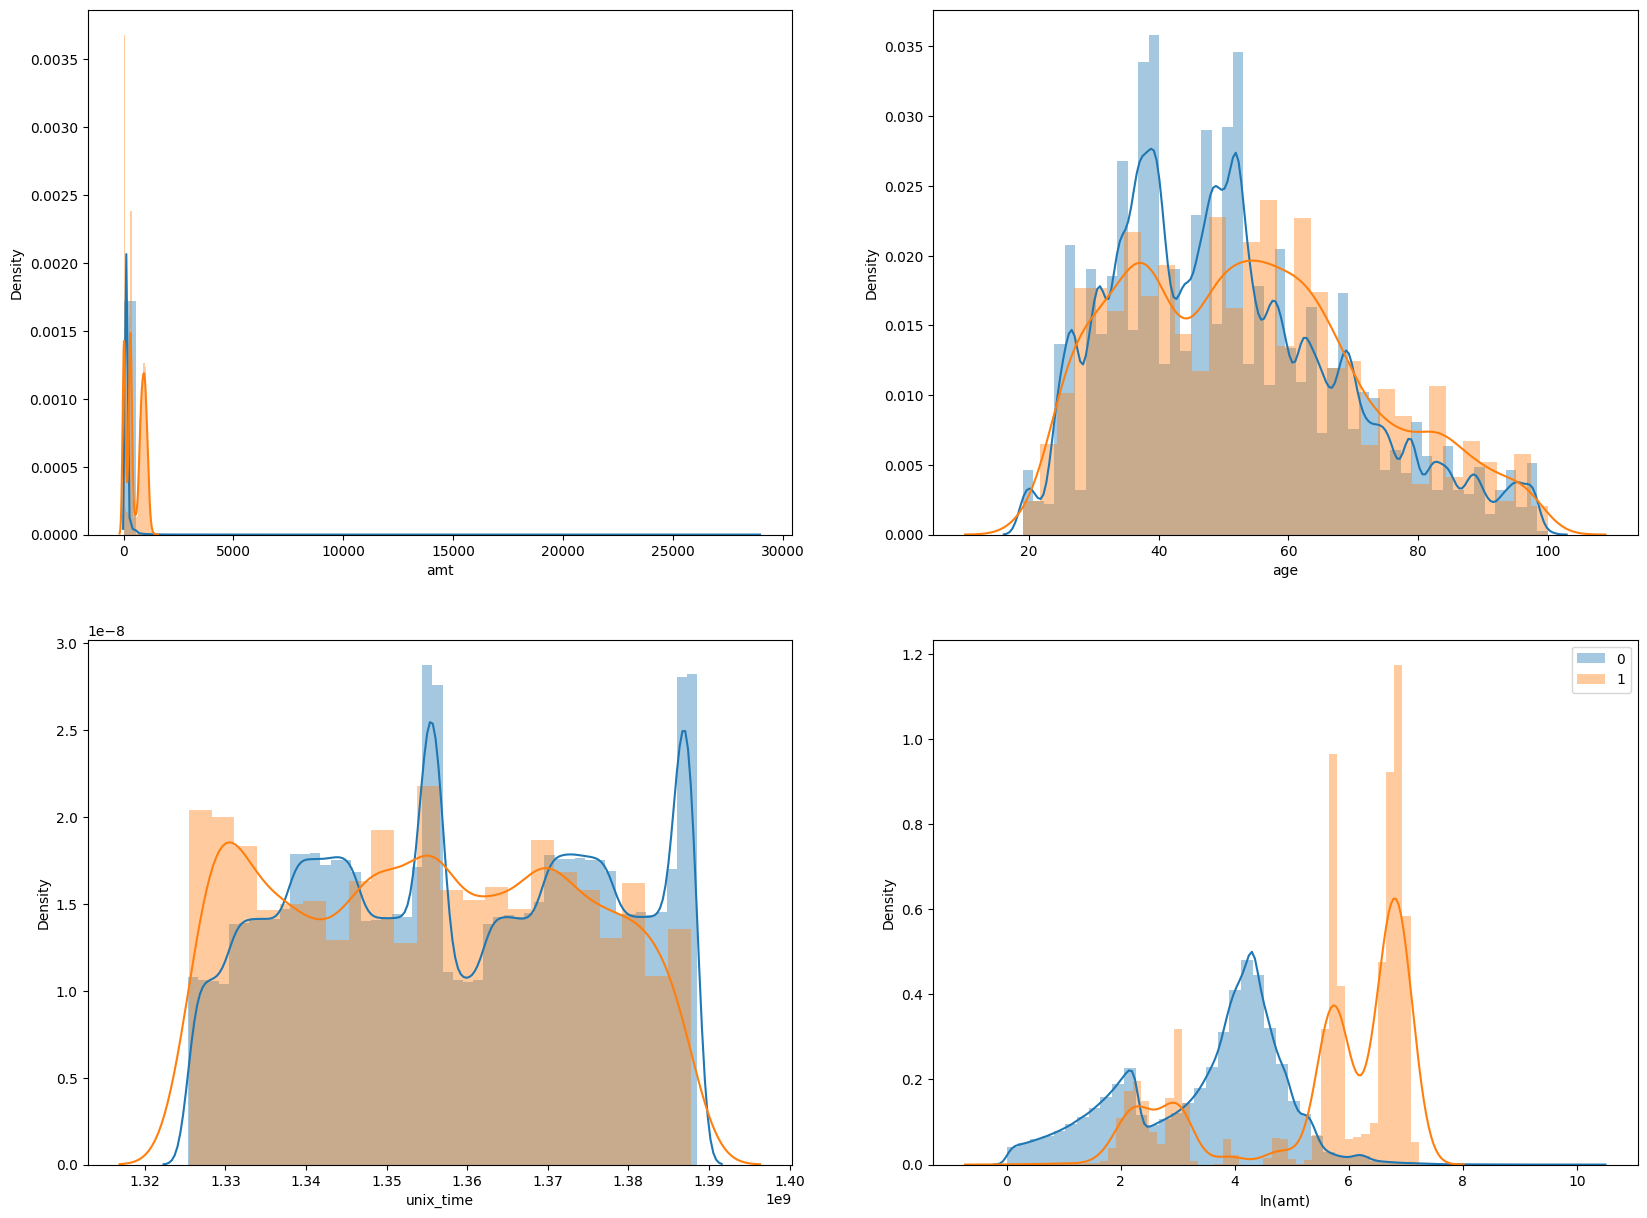

In [42]:
target_histograms(numerical_data, x = ['amt', 'age', 'unix_time', 'ln(amt)'], y = 'is_fraud', shape = (2, 2), figsize = (20, 15))

`We can see a difference now between fraudulent and non fraudulent transaction`

In [43]:
import scipy.stats as stats

fraud_amt = numerical_data[numerical_data['is_fraud'] == 1]['ln(amt)']
non_fraud_amt = numerical_data[numerical_data['is_fraud'] == 0]['ln(amt)'].sample(len(fraud_amt))

assert len(fraud_amt) == len(non_fraud_amt)
stats.mannwhitneyu(non_fraud_amt, fraud_amt)

MannwhitneyuResult(statistic=15535186.5, pvalue=0.0)

# Gender vs Fraud

In [44]:
gender_fraud = all_data.select('gender', 'is_fraud').toPandas()

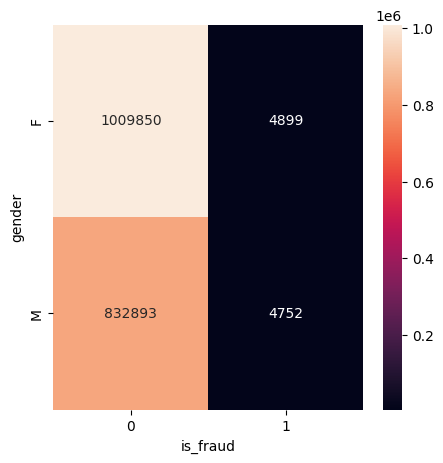

In [45]:
crosstabs(gender_fraud, gender_fraud.columns, shape = (1, 1), figsize = (5, 5))

`Nothing to say about the impact of gender on frauds`

# City population

In [58]:
city_pop_data = all_data.select('city_pop', 'is_fraud').toPandas()

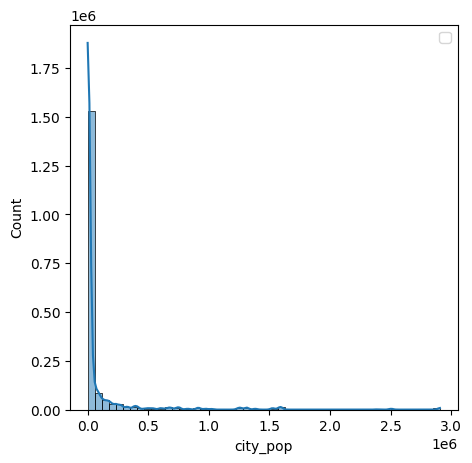

In [60]:
histograms(city_pop_data, x = ['city_pop'], shape = (1, 1), figsize = (5, 5), params = {'bins': 50, 'kde': True})

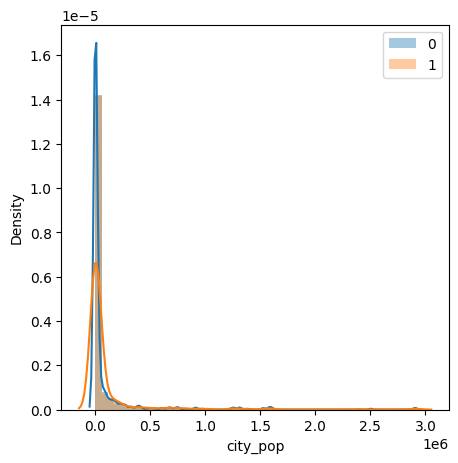

In [61]:
target_histograms(city_pop_data, x = ['city_pop'], y = 'is_fraud', shape = (1, 1), figsize = (5, 5))

In [70]:
city_pop_data['ln(city_pop)'] = np.log(city_pop_data['city_pop'])
city_pop_data['sqrt(city_pop)'] = np.sqrt(city_pop_data['city_pop'])

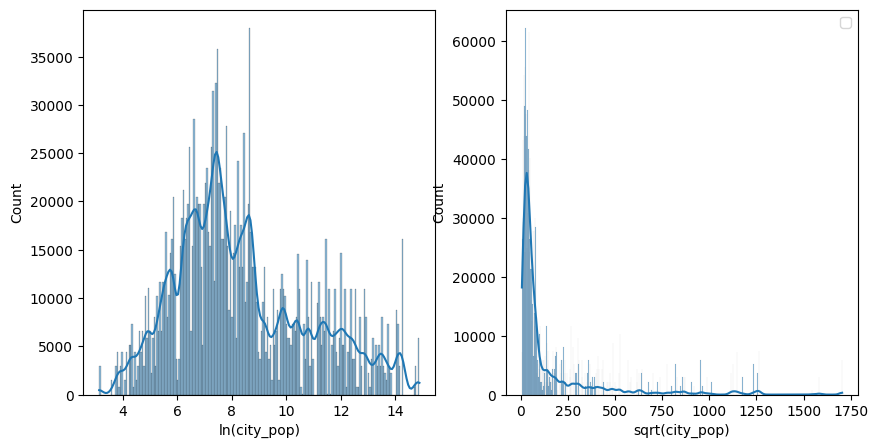

In [71]:
histograms(city_pop_data, x = ['ln(city_pop)', 'sqrt(city_pop)'], shape = (1, 2), figsize = (10, 5), params = {'kde': True})

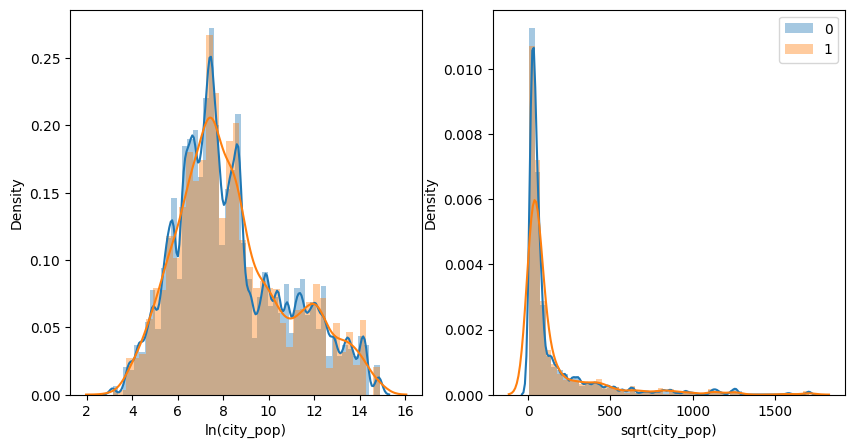

In [73]:
target_histograms(city_pop_data, x = ['ln(city_pop)', 'sqrt(city_pop)'], y = 'is_fraud', shape = (1, 2), figsize = (10, 5))

`No difference between both`

In [77]:
all_data.columns

['_c0',
 'trans_date_trans_time',
 'merchant',
 'category',
 'amt',
 'gender',
 'state',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'age',
 'trans_hour']

# Long and lat

In [81]:
coordinates_data = all_data.select('long', 'lat', 'merch_long', 'merch_lat', 'is_fraud').toPandas()

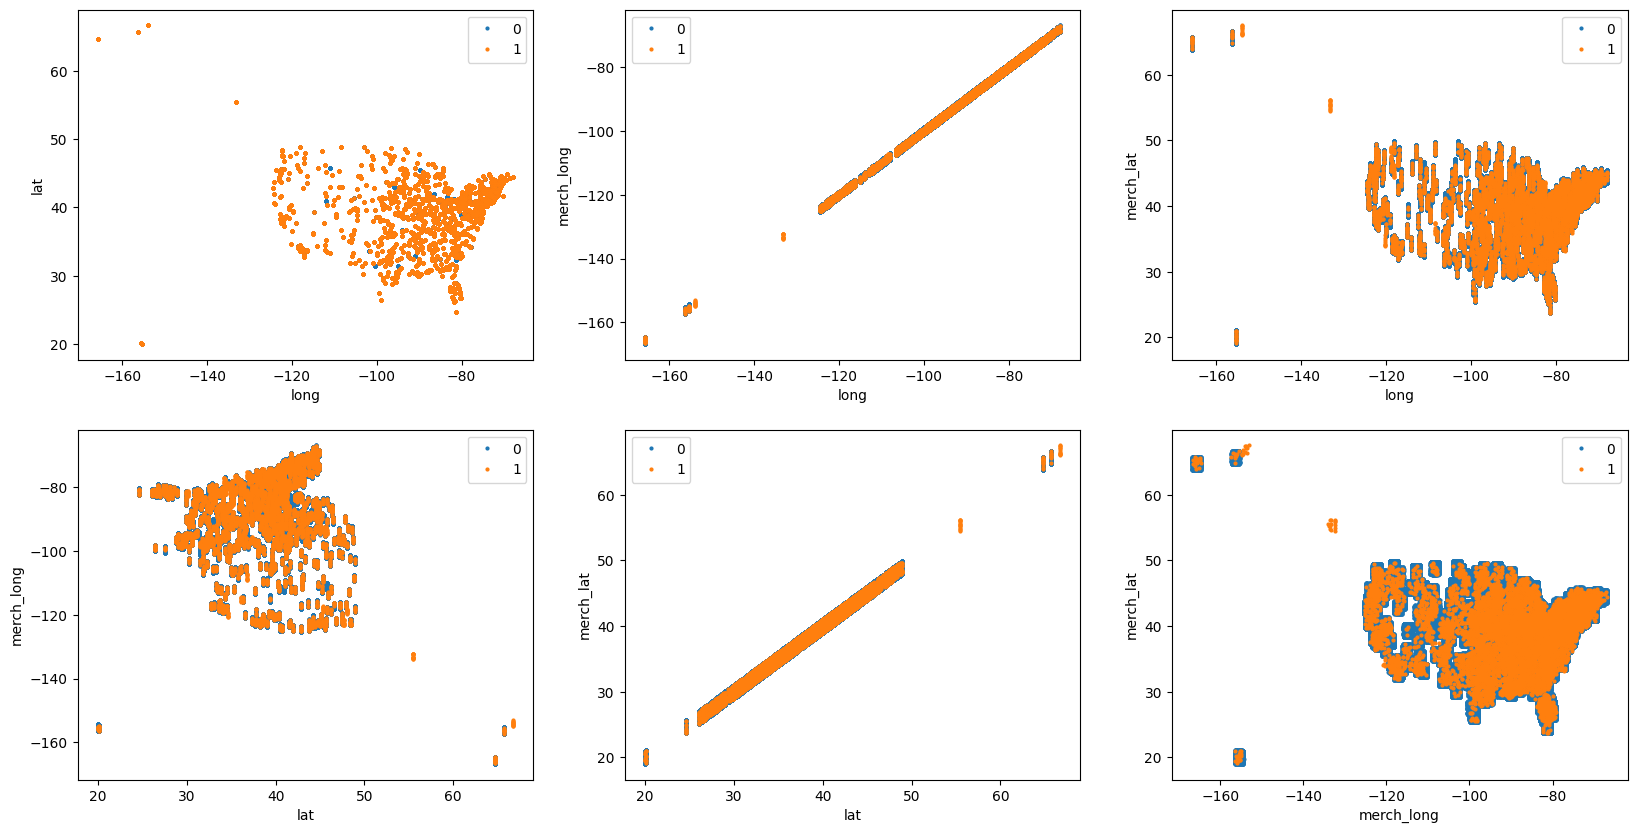

In [135]:
scatter_plots(coordinates_data, x = ['long', 'lat', 'merch_long', 'merch_lat'], y = 'is_fraud', shape = (2, 3), figsize = (20, 10))

`Not a big difference between fraudulent and non fraudulent transactions`

# Saving data

In [136]:
train = train.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
test = test.withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))

In [137]:
train = train.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
test = test.withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))

In [138]:
finalTrain = train.select('amt', 'age', 'trans_hour', 'state', 'is_fraud')
finalTest = test.select('amt', 'age', 'trans_hour', 'state', 'is_fraud')

output_path = "Datasets"

finalTrain.toPandas().to_csv(os.path.join(output_path, 'finalTrain.csv'))
finalTest.toPandas().to_csv(os.path.join(output_path, 'finalTest.csv'))

In [139]:
all_data.toPandas().to_csv(os.path.join(output_path, 'allData.csv'))